## MOM01 Temp Evaluations
#plots surface and zonal average temps across simulations
#computes anomalies relative to longterm average of WOA data
#takes forever to run thru all expts, I suggest trying a subset 
#expts = ['GFDL50','KDS75']
#still need to convert WOA insitu temp to potential temp: not sure how to vectorize this.

In [1]:
# Load modules
%pylab inline
from netCDF4 import Dataset # to work with NetCDF files
import numpy as np
import matplotlib.pyplot as plt # to generate plots
from mpl_toolkits.basemap import Basemap # plot on map projections
from os.path import expanduser
home = expanduser("~") # Get users home directory
import os # operating system interface

import xarray
from xarray.ufuncs import square, sqrt
import scipy.interpolate

#import scipy
#sfrom scipy.interpolate import RegularGridInterpolator, griddata

#import dask
#from dask import delayed
#import dask.array as da
#import dask.dataframe as dd
#from dask.multiprocessing import get
#from dask.async import get_sync
#from dask.diagnostics import ProgressBar

#import pandas as pd
#from glob import glob


Populating the interactive namespace from numpy and matplotlib


In [2]:
#pbar = ProgressBar()
#pbar.register()

In [3]:
# set up dask to initiate 4 parallel processors.
#this doesn't work yet
#dask.set_options(get=dask.multiprocessing.get, num_workers=4)

In [4]:
#extract the MOM model grid info - 50 and 75 vertical levels
hgrid_file ='/g/data1/v45/pas561/mom/archive/VertOverturn/mom01_unmasked_ocean_grid.nc'
vgrid75_file ='/g/data1/v45/pas561/mom/archive/VertOverturn/kds75.uvwt.230-257.ncra.nc'
vgrid50_file ='/g/data3/hh5/tmp/cosima/mom01v5/GFDL50/gfdl50.uvwt.384_403.ncra.nc'

# Extract the variables
nc = Dataset(hgrid_file, mode='r') # file handle, open in read only mode
geolon_t = nc.variables['geolon_t'][:]
geolat_t = nc.variables['geolat_t'][:]
area_t = nc.variables['area_t'][:]
dxt = nc.variables['dxt'][:]
dyt = nc.variables['dyt'][:]
nc.close() # close the file
print geolon_t.shape

nc = Dataset(vgrid75_file, mode='r') # file handle, open in read only mode
sw75_ocean = nc.variables['sw_ocean'][:]
st75_ocean = nc.variables['st_ocean'][:]
yt_ocean = nc.variables['yt_ocean'][:]
xt_ocean = nc.variables['xt_ocean'][:]
nc.close() # close the file

nc = Dataset(vgrid50_file, mode='r') # file handle, open in read only mode
sw50_ocean = nc.variables['sw_ocean'][:]
st50_ocean = nc.variables['st_ocean'][:]
yt_ocean = nc.variables['yt_ocean'][:]
nc.close() # close the file

print st75_ocean.shape
print st50_ocean.shape


(2700, 3600)
(75,)
(50,)


(1, 102, 720, 1440)
(1, 102, 720, 1440)
(720, 1440)
(1440,)
(720,)
(3600,)
(2700, 3600)


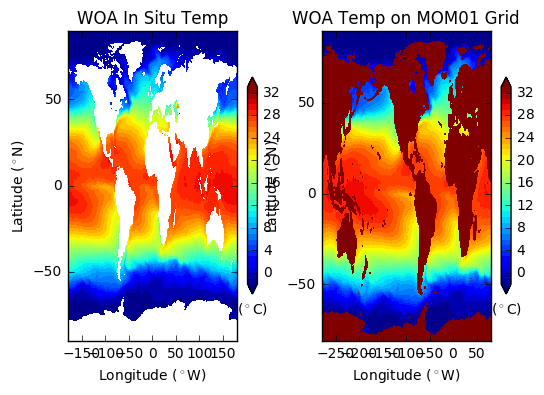

In [5]:
#Get WOA observed Temp (In Situ) data and interpolate SST onto Model Grids
#Still need to convert to potential Temp
#Shifts Lon values to match model and then interpolates

temp_obs_file ='/g/data1/v45/pas561/mom/archive/WOA/woa13_decav_t00_04v2.nc'

x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)

# Extract the variables
nc = Dataset(temp_obs_file, mode='r') # file handle, open in read only mode
lon = nc.variables['lon'][:]
lat = nc.variables['lat'][:]
zt = nc.variables['depth'][:]
t_an = nc.variables['t_an'][:]
#mld = nc.variables['mld'][:]
#ty_trans_rho = nc.variables['ty_trans_rho'][0,:,:,:]
nc.close() # close the file
print t_an.shape

plt.subplot(1,2,1)
clev = np.arange(-2,34,1)
plt.contourf(lon,lat,t_an[0,0,:,:],levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('($^\circ$C)')
plt.xlabel('Longitude ($^\circ$W)')
plt.ylabel('Latitude ($^\circ$N)')
plt.title('WOA In Situ Temp')

#re-arrange lon values (-180:180) to match xt_ocean (-280:80)
lon[lon>80] -= 360
lon_copy = np.ma.copy(lon)
shift_index0 = np.argmin(lon)
shift_index1 = len(lon) - shift_index0
lon[:shift_index1] = lon_copy[shift_index0:]
lon[shift_index1:] = lon_copy[:shift_index0]

t_an_copy = np.ma.copy(t_an)
t_an[:,:,:,:shift_index1] = t_an_copy[:,:,:,shift_index0:]
t_an[:,:,:,shift_index1:] = t_an_copy[:,:,:,:shift_index0]
#t_an_c = np.ma.masked_invalid(t_an)
print t_an.shape

sst=t_an[0,0,:,:]
print sst.shape
print lon.shape
print lat.shape
print xt_ocean.shape
#convert lon and lat to 2d arrays
lon_2d,lat_2d = np.meshgrid(lon,lat)
#amps_u_interp = scipy.interpolate.griddata((lon.flatten(),lat.flatten()),sst.flatten(),(xt_2d,yt_2d),method='linear')
woa_sst_interp = scipy.interpolate.griddata((lon_2d.flatten(),lat_2d.flatten()),sst.flatten(),(geolon_t,geolat_t),method='linear')
# I found I needed this to mask a bunch of NaNs after:
woa_sst_interp = np.ma.masked_invalid(woa_sst_interp)
print woa_sst_interp.shape

plt.subplot(1,2,2)
clev = np.arange(-2,34,1)
plt.contourf(geolon_t,geolat_t,woa_sst_interp,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('($^\circ$C)')
plt.xlabel('Longitude ($^\circ$W)')
plt.ylabel('Latitude ($^\circ$N)')
plt.title('WOA Temp on MOM01 Grid')



(102, 720)
(102,)
(720,)
(75,)
(50,)
(75, 2700)
(50, 2700)


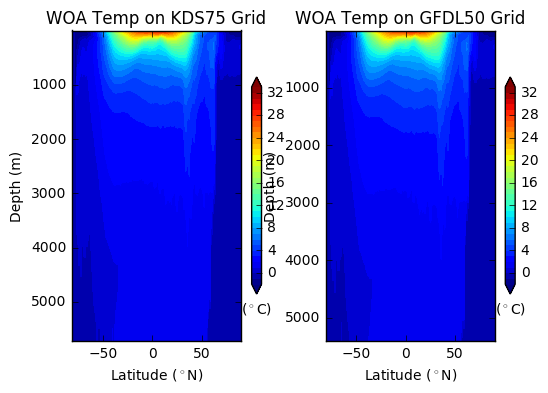

In [6]:
#Get WOA observed Temp (In Situ) data and calculate zonal average
#interpolate zonal average onto MOM grids - 50 and 75 vertical levels
#Still need to convert from in situ to potential Temp

x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)

zavgt=np.ma.mean(t_an[0,:,:,:],axis=2)
print zavgt.shape
print zt.shape
print lat.shape
print st75_ocean.shape
print st50_ocean.shape


########## for 1D lat/long coords, can change degree of kx for improved fit if needed:
from scipy.interpolate import RectBivariateSpline
f = RectBivariateSpline(zt,lat,zavgt,kx=1,ky=1)
woa_zavg75_interp = f(st75_ocean,yt_ocean)
# I found I needed this to mask a bunch of NaNs after:
woa_zavg75_interp  = np.ma.masked_invalid(woa_zavg75_interp)
print woa_zavg75_interp.shape

plt.subplot(1,2,1)
clev = np.arange(-2,34,1)
plt.contourf(yt_ocean,st75_ocean,woa_zavg75_interp,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('($^\circ$C)')
plt.gca().invert_yaxis()
plt.ylabel('Depth (m)')
plt.xlabel('Latitude ($^\circ$N)')
plt.title('WOA Temp on KDS75 Grid')

########## for 1D lat/long coords, can change degree of kx for improved fit if needed:
from scipy.interpolate import RectBivariateSpline
f = RectBivariateSpline(zt,lat,zavgt,kx=1,ky=1)
woa_zavg50_interp = f(st50_ocean,yt_ocean)
# I found I needed this to mask a bunch of NaNs after:
woa_zavg50_interp  = np.ma.masked_invalid(woa_zavg50_interp)
print woa_zavg50_interp.shape

plt.subplot(1,2,2)
clev = np.arange(-2,34,1)
plt.contourf(yt_ocean,st50_ocean,woa_zavg50_interp,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('($^\circ$C)')
plt.gca().invert_yaxis()
plt.ylabel('Depth (m)')
plt.xlabel('Latitude ($^\circ$N)')
plt.title('WOA Temp on GFDL50 Grid')

In [14]:
DataDir = '/g/data3/hh5/tmp/cosima/mom01v5'

expts = ['GFDL50','KDS75','KDS75_UP','KDS75_PI']
#expts = ['GFDL50','KDS75']

In [15]:
#calculate annual mean surface and zonal average temp from last year of MOM runs

#should probably do this with lists? but takes forever to convert to numpy array
sst=np.zeros((len(expts),yt_ocean.shape[0],xt_ocean.shape[0]))
zavg75=np.zeros((len(expts)-1,st75_ocean.shape[0],yt_ocean.shape[0]))
zavg50=np.zeros((1,st50_ocean.shape[0],yt_ocean.shape[0]))

ii=0
for e in expts:
        
    ExpDir = os.path.join(DataDir,e)
    
    if e=="GFDL50":
        OceanFile = os.path.join(DataDir,e,'output4*/ocean.nc')
        avgt=4
    if e=="KDS75":
        OceanFile = os.path.join(DataDir,e,'output4*/ocean_month.nc')
        avgt=12
    if e=="KDS75_UP":
        OceanFile = os.path.join(DataDir,e,'output3*/ocean.nc')
        avgt=4
    if e=="KDS75_PI":
        OceanFile = os.path.join(DataDir,e,'output3*/ocean.nc')
        avgt=4
        
    print OceanFile
    ff=xarray.open_mfdataset(OceanFile,engine='netcdf4',concat_dim='time',decode_times=False,
                               chunks={'time':1,'st_ocean':5,'xt_ocean':338,'yt_ocean':450})
    
    tavg=ff.temp[-avgt:,1,:,:].mean('time').load()
    print tavg.shape
    sst[ii,:,:]=tavg
    
    if ff.st_ocean.shape[0]==50:
        zavg50[0,:,:]=ff.temp[-avgt:,:,:,:].mean('time').mean('xt_ocean').load()
        print ff.st_ocean.shape[0]
    if ff.st_ocean.shape[0]==75:
        zavg75[ii-1,:,:]=ff.temp[-avgt:,:,:,:].mean('time').mean('xt_ocean').load()
        print ff.st_ocean.shape[0]
    
    ii+=1
    


/g/data3/hh5/tmp/cosima/mom01v5/GFDL50/output4*/ocean.nc
(2700, 3600)
50
/g/data3/hh5/tmp/cosima/mom01v5/KDS75/output4*/ocean_month.nc
(2700, 3600)
75
/g/data3/hh5/tmp/cosima/mom01v5/KDS75_UP/output3*/ocean.nc
(2700, 3600)
75
/g/data3/hh5/tmp/cosima/mom01v5/KDS75_PI/output3*/ocean.nc
(2700, 3600)
75


1 GFDL50
2 KDS75
3 KDS75_UP
4 KDS75_PI


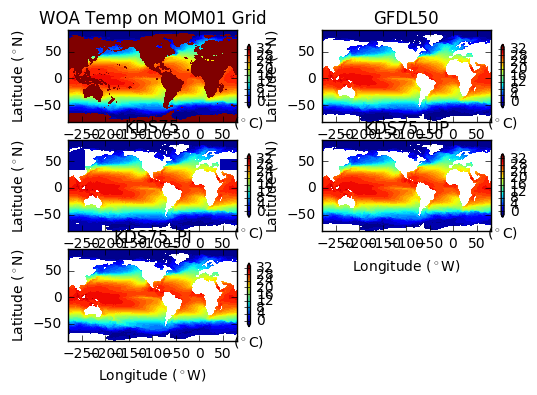

In [19]:
#plot annual mean surface temp from last year of MOM runs

plt.subplot(3,2,1)
clev = np.arange(-2,34,1)
plt.contourf(geolon_t,geolat_t,woa_sst_interp,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('($^\circ$C)')
plt.xlabel('Longitude ($^\circ$W)')
plt.ylabel('Latitude ($^\circ$N)')
plt.title('WOA Temp on MOM01 Grid')

ii=0
for e in expts:
        
    #plot full SST
    plt.subplot(3,2,ii+2)
    clev = np.arange(-2,34,1)
    plt.contourf(geolon_t,geolat_t,sst[ii,:,:],levels=clev,extend='both')
    cb=plt.colorbar(orientation='vertical',shrink = 0.7)
    cb.ax.set_xlabel('($^\circ$C)')
    plt.xlabel('Longitude ($^\circ$W)')
    plt.ylabel('Latitude ($^\circ$N)')
    plt.title(e)
    
    ii+=1
    print ii,e

plt.savefig('mom01_sst.pdf')

GFDL50
KDS75
KDS75_UP
KDS75_PI


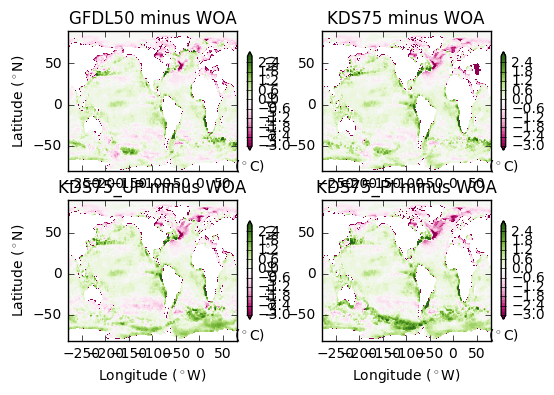

In [20]:
#plot SST anomalies relative to WOA obs data on model grid

ii=0
for e in expts:
        
    #plot full SST
    plt.subplot(2,2,ii+1)
    clev = np.arange(-3,3,.2)
    plt.contourf(geolon_t,geolat_t,sst[ii,:,:]-woa_sst_interp,cmap=plt.cm.PiYG,levels=clev,extend='both')
    cb=plt.colorbar(orientation='vertical',shrink = 0.7)
    cb.ax.set_xlabel('($^\circ$C)')
    plt.xlabel('Longitude ($^\circ$W)')
    plt.ylabel('Latitude ($^\circ$N)')
    plt.title(e+ " minus WOA")
    
    ii+=1
    print e
    
plt.savefig('mom01_sstanom.pdf')

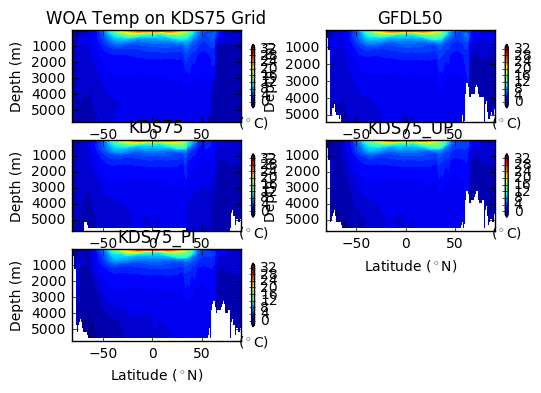

In [21]:
#plot annual mean zonal average temp from last year of MOM runs and WOA
plt.subplot(3,2,1)
clev = np.arange(-2,34,1)
plt.contourf(yt_ocean,ff.st_ocean,woa_zavg75_interp,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('($^\circ$C)')
plt.gca().invert_yaxis()
plt.ylabel('Depth (m)')
plt.xlabel('Latitude ($^\circ$N)')
plt.title('WOA Temp on KDS75 Grid')
    

ii=0
for e in expts:
    
    if e=="GFDL50":
        plt.subplot(3,2,ii+2)
        clev = np.arange(-2,34,1)
        plt.contourf(yt_ocean,st50_ocean,zavg50[ii,:,:],levels=clev,extend='both')
        cb=plt.colorbar(orientation='vertical',shrink = 0.7)
        cb.ax.set_xlabel('($^\circ$C)')
        plt.gca().invert_yaxis()
        plt.ylabel('Depth (m)')
        plt.xlabel('Latitude ($^\circ$N)')
        plt.title(e)

    else:
        plt.subplot(3,2,ii+2)
        clev = np.arange(-2,34,1)
        plt.contourf(yt_ocean,st75_ocean,zavg75[ii-1,:,:],levels=clev,extend='both')
        cb=plt.colorbar(orientation='vertical',shrink = 0.7)
        cb.ax.set_xlabel('($^\circ$C)')
        plt.gca().invert_yaxis()
        plt.ylabel('Depth (m)')
        plt.xlabel('Latitude ($^\circ$N)')
        plt.title(e)
    
    ii+=1
plt.savefig('mom01_zavT.pdf')

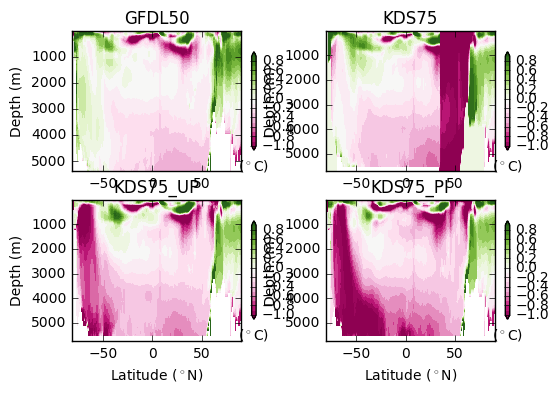

In [22]:
#plot zonal average anomaly relative to WOA
ii=0
for e in expts:
    
    if e=="GFDL50":
        plt.subplot(2,2,ii+1)
        clev = np.arange(-1,1,.1)
        plt.contourf(yt_ocean,st50_ocean,zavg50[ii,:,:]-woa_zavg50_interp,cmap=plt.cm.PiYG,levels=clev,extend='both')
        cb=plt.colorbar(orientation='vertical',shrink = 0.7)
        cb.ax.set_xlabel('($^\circ$C)')
        plt.gca().invert_yaxis()
        plt.ylabel('Depth (m)')
        plt.xlabel('Latitude ($^\circ$N)')
        plt.title(e)

    else:
        plt.subplot(2,2,ii+1)
        clev = np.arange(-1,1,.1)
        plt.contourf(yt_ocean,st75_ocean,zavg75[ii-1,:,:]-woa_zavg75_interp,cmap=plt.cm.PiYG,levels=clev,extend='both')
        cb=plt.colorbar(orientation='vertical',shrink = 0.7)
        cb.ax.set_xlabel('($^\circ$C)')
        plt.gca().invert_yaxis()
        plt.ylabel('Depth (m)')
        plt.xlabel('Latitude ($^\circ$N)')
        plt.title(e)
    
    ii+=1
plt.savefig('mom01_zavgTanom.pdf')